In [4]:
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from numpy import e
from matplotlib import pyplot as plt
import torch.optim as optim
from tqdm.notebook import tqdm

from aijack.collaborative.fedavg import FedAVGAPI, FedAVGClient, FedAVGServer
from aijack.attack.inversion import GradientInversionAttackServerManager
from torch.utils.data import DataLoader, TensorDataset
from aijack.utils import NumpyDataset

import warnings

warnings.filterwarnings("ignore")

In [5]:
class LeNet(nn.Module):
    def __init__(self, channel=3, hideen=768, num_classes=10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            nn.BatchNorm2d(12),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            nn.BatchNorm2d(12),
            act(),
        )
        self.fc = nn.Sequential(nn.Linear(hideen, num_classes))

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [6]:
def prepare_dataloader(path="MNIST/.", batch_size=64, shuffle=True):
    at_t_dataset_train = torchvision.datasets.MNIST(
        root=path, train=True, download=True
    )

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    dataset = NumpyDataset(
        at_t_dataset_train.train_data.numpy(),
        at_t_dataset_train.train_labels.numpy(),
        transform=transform,
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0
    )
    return dataloader

In [7]:
torch.manual_seed(7777)

shape_img = (28, 28)
num_classes = 10
channel = 1
hidden = 588

num_seeds = 5

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|███████████████████████████████████████████████| 9.91M/9.91M [00:12<00:00, 815kB/s]


Extracting MNIST/./MNIST/raw/train-images-idx3-ubyte.gz to MNIST/./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 40.3kB/s]


Extracting MNIST/./MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|███████████████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 218kB/s]


Extracting MNIST/./MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.23MB/s]

Extracting MNIST/./MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/./MNIST/raw



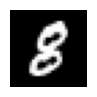

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dataloader = prepare_dataloader()
for data in dataloader:
    xs, ys = data[0], data[1]
    break

x = xs[:1]
y = ys[:1]

fig = plt.figure(figsize=(1, 1))
plt.axis("off")
plt.imshow(x.detach().numpy()[0][0], cmap="gray")
plt.show()

In [9]:
criterion = nn.CrossEntropyLoss()

communication 0, epoch 0: client-1 2.265911817550659
iter=10: 1.5233003978210036e-06, (best_iter=10: 1.5233003978210036e-06)
iter=20: 3.2193455012929917e-07, (best_iter=20: 3.2193455012929917e-07)
iter=30: 2.0974960435182766e-08, (best_iter=30: 2.0974960435182766e-08)
iter=40: 1.9549579732824895e-08, (best_iter=32: 1.9549579732824895e-08)
iter=50: 1.9549579732824895e-08, (best_iter=32: 1.9549579732824895e-08)
iter=60: 1.9549579732824895e-08, (best_iter=32: 1.9549579732824895e-08)
iter=70: 1.9549579732824895e-08, (best_iter=32: 1.9549579732824895e-08)
iter=80: 1.9549579732824895e-08, (best_iter=32: 1.9549579732824895e-08)
iter=83: loss did not improve in the last 50 rounds.
iter=10: 1.5749194517411524e-06, (best_iter=10: 1.5749194517411524e-06)
iter=20: 2.5980137152714633e-08, (best_iter=16: 2.5980137152714633e-08)
iter=30: 2.5980137152714633e-08, (best_iter=16: 2.5980137152714633e-08)
iter=40: 2.5980137152714633e-08, (best_iter=16: 2.5980137152714633e-08)
iter=50: 2.5980137152714633e-0

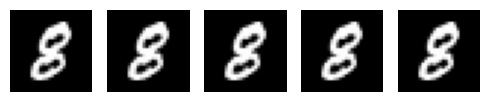

In [18]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=10,
    num_iteration=100,
    distancename="l2",
    device=device,
    lr=1.0,
)
DLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = DLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

communication 0, epoch 0: client-1 2.265911817550659
iter=74: loss did not improve in the last 50 rounds.
iter=72: loss did not improve in the last 50 rounds.
iter=83: loss did not improve in the last 50 rounds.
iter=78: loss did not improve in the last 50 rounds.


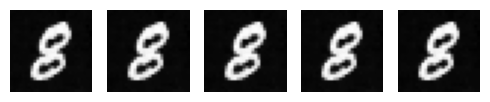

In [11]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=100,
    tv_reg_coef=0.01,
    distancename="cossim",
    device=device,
    lr=1.0,
)
GSFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = GSFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


communication 0, epoch 0: client-1 2.265911817550659


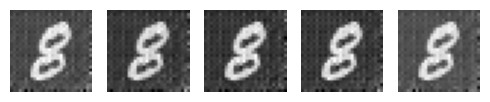

In [12]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=1000,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    device=device,
    lr=1.0,
)
iDLGFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)
server = iDLGFedAVGServer(
    [client],
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device),
    lr=1.0,
    device=device,
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
    device=device,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


communication 0, epoch 0: client-1 2.3563129901885986


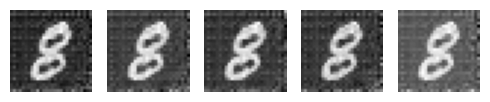

In [13]:
manager = GradientInversionAttackServerManager(
    (1, 28, 28),
    num_trial_per_communication=5,
    log_interval=0,
    num_iteration=1000,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    lm_reg_coef=0.01,
    lr=1.0,
)
CPLFedAVGServer = manager.attach(FedAVGServer)

client = FedAVGClient(
    LeNet(channel=channel, hideen=hidden, num_classes=num_classes), lr=1.0
)
server = CPLFedAVGServer(
    [client], LeNet(channel=channel, hideen=hidden, num_classes=num_classes), lr=1.0
)

local_dataloaders = [DataLoader(TensorDataset(x, y))]
local_optimizers = [optim.SGD(client.parameters(), lr=1.0)]

api = FedAVGAPI(
    server,
    [client],
    criterion,
    local_optimizers,
    local_dataloaders,
    num_communication=1,
    local_epoch=1,
    use_gradients=True,
)

api.run()

fig = plt.figure(figsize=(5, 2))
for s, result in enumerate(server.attack_results[0]):
    ax = fig.add_subplot(1, len(server.attack_results[0]), s + 1)
    ax.imshow(result[0].cpu().detach().numpy()[0][0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

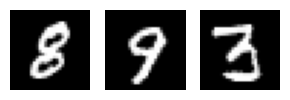

In [14]:
batch_size = 3
x_batch = xs[:batch_size]
y_batch = ys[:batch_size]

fig = plt.figure(figsize=(3, 2))
for bi in range(batch_size):
    ax = fig.add_subplot(1, batch_size, bi + 1)
    ax.imshow(x_batch[bi].detach().numpy()[0], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

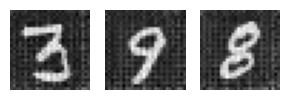

In [15]:
from aijack.attack.inversion import GradientInversion_Attack

net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes)
pred = net(x_batch)
loss = criterion(pred, y_batch)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

gradinversion = GradientInversion_Attack(
    net,
    (1, 28, 28),
    num_iteration=1000,
    lr=1e2,
    log_interval=0,
    optimizer_class=torch.optim.SGD,
    distancename="l2",
    optimize_label=False,
    bn_reg_layers=[net.body[1], net.body[4], net.body[7]],
    group_num=3,
    tv_reg_coef=0.00,
    l2_reg_coef=0.0001,
    bn_reg_coef=0.001,
    gc_reg_coef=0.001,
)

result = gradinversion.group_attack(received_gradients, batch_size=batch_size)

fig = plt.figure(figsize=(3, 2))
for bid in range(batch_size):
    ax1 = fig.add_subplot(1, batch_size, bid + 1)
    ax1.imshow((sum(result[0]) / len(result[0])).detach().numpy()[bid][0], cmap="gray")
    ax1.axis("off")
plt.tight_layout()
plt.show()